# VCC Laser Beam Shaping Simulation Example

## Initial imports/function definitions

In [416]:
%matplotlib widget
import os, sys
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('petrstyle.txt')
from matplotlib.ticker import NullFormatter
import glob, h5py
import shutil
import scipy.io
import pandas as pd
import pydicom as dicom
import cv2

from astra import Astra#, template_dir
from astra.plot import plot_fieldmaps, plot_stats, plot_stats_with_layout
import distgen
from distgen import Generator
from distgen.writers import *
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.plot import marginal_plot

#slice plots
# from h5py import File
# from pmd_beamphysics.interfaces import opal
# from pmd_beamphysics.plot import slice_plot
# from pmd_beamphysics.plot import marginal_plot, density_plot

In [417]:
def parse_opal_emitted_dist(filename, names=['x', 'px','y','py','t','pz']):
    '''Read in particle distribution used 
    in OPAL-T simulation. Used to describe the 
    beam distribution as it leaves the cathode.'''
    dist = {}
    data = np.loadtxt(filename, skiprows=1)
    for i,name in enumerate(names):
        dist[name] = data[:,i]
    return dist
    
def parse_astra_dist(filename, header=['x', 'y', 'z', 'px','py', 'pz', 't', 'Q', 'ptype', 'flag']):
    '''
    Read in initial particle distribution used 
    in ASTRA simulation. Used to describe the 
    beam distribution as it leaves the cathode.
   
    t     = time in ns
    Q     = macro charge
    ptype = particle type (electron: 1)
    flag  = particle location (cathode: -1)
    '''
    #print(filename)
    data = pd.read_csv(filename, delim_whitespace=True, names=header)
    #print(data)
    #only return non traj probe particles at cathodeprint(astradist['z'])
    dist = data[data.flag == -1]
    return dist #dist

In [418]:
def make_tri(n, xmin, xmax, x):

    half = int(n/2)
    yr  = np.zeros(half*2)
    #step 1
    nr = int(n)
    xr = np.random.rand(nr)

    for j in range(0,nr):
        #step 3
        if j < half:
            yr[j] = (1- np.sqrt(1-xr[j]))*(xmax-xmin)  
        elif j >= half:
        #step 4 
            yr[j] = (-1 + np.sqrt(1-xr[j]))*(xmax-xmin) 

    #showplot(xr, yr)
    for k in range(0,len(x)):
        #print(y[k])
        if (-yr[k]/8 <= x[k] <= yr[k]/8):
            pass
            #x[k]=0
        else:
            #print(x[k])
            x[k]=0
            #pass

    #showplot(xr,x)
    return x, xr

### Distgen file generation

In [419]:
# From Chris: https://github.com/slaclab/lcls-lattice/tree/master/distgen/models/cu_inj/vcc_image
def write_distgen_xy_dist(filename, image, resolution, resolution_units='m'):
    """
    Writes image data in distgen's xy_dist format
    
    Returns the absolute path to the file written
    
    """
    
    # Get width of each dimension
    widths = resolution * np.array(image.shape)
    
    # Form header
    header = f"""x {widths[1]} {widths[1]/2} [{resolution_units}]
y {widths[0]} {widths[0]/2}  [{resolution_units}]"""
    
    # Save with the correct orientation
    np.savetxt(filename, np.flip(image, axis=0), header=header, comments='')
    
    return os.path.abspath(filename)

### Setting the path of the ASTRA_BIN

In [420]:
#Possible generalization for environment dependency path
os.environ['ASTRA_BIN'] = os.getenv('ASTRA_BIN')
#print(os.getenv('ASTRA_BIN'))

In [421]:
#Edit this line to match your path if the above cell doesn't work
#%env ASTRA_BIN=/Users/colinrecker/Desktop/SLACForks/Astra

## Loading Laser Image

### Initializing the laser image

In [422]:
#Loads and returns reshaped laser image based on index
def laser_load(index):
    mat = scipy.io.loadmat(vcc[index])
    #Scraping Name of File
    global laser_name
    laser_name = str(mat['data'][0][0][0][0])

    #Image Reshaping
    arr = mat['data']
    dim = arr.shape[0]
    #print(dim)
    xy = int(np.sqrt(dim))
    nrow = xy
    ncol = xy
    return arr.reshape(nrow, ncol)[0][0][1], xy

### New dcm directory creation

In [423]:
def dcm_mkdir(name):
    #makes scan directory
    os.mkdir(os.path.join(sim_path, name))
    scan_path = os.path.join(sim_path, name)

    #makes data and plots directory
    data_path = os.path.join(scan_path, 'data')
    plots_path = os.path.join(scan_path, 'plots')
    os.mkdir(data_path)
    os.mkdir(plots_path)

    #defining directories to add to data and plots
    
    #directories used b y functions
    data_dirs = ['dcm_crop', 'cont_scan']
    #plot directories
    plots_dirs = ['animations', 'compare_dist',  'energy_dist', 'final_electron_dist', 'init_electron_dist', 'laser_images', 'compare_dist_rotated']
    for dir in data_dirs:
        os.mkdir(os.path.join(data_path, dir))
    for dir in plots_dirs:
        os.mkdir(os.path.join(plots_path, dir))

    #copies .dcm to scan_path directory
    shutil.copy2(init_dcm_path, scan_path)

### Path definitions

In [465]:
#define xta repo path
xta_path = '/Users/colinrecker/Desktop/SLACForks/xta'
os.chdir(xta_path)

#define simulation data directory path
sim_path = '/Users/colinrecker/Google Drive/My Drive/Colin/Simulations'

#Loads all example laser images into list
vcc = glob.glob(f'{sim_path}/data/laser_mat_images/*.mat')

#defining tumor scan
init_dcm_path = os.path.join(sim_path, 'Fluence Maps Anon', 'Field 1 Anon', 'field1.dcm')
image_name = os.path.splitext(os.path.split(init_dcm_path)[-1])[0]

#Creates scan directory
if not os.path.exists(os.path.join(sim_path, image_name)):
    dcm_mkdir(image_name)
    print(f'Created new directory for {image_name}')

scan_path = os.path.join(sim_path, image_name)

#path to directories
plots_path = os.path.join(scan_path,'plots')
data_path = os.path.join(scan_path, 'data')

Created new directory for field1


### Plotting Laser Image

In [466]:
IMAGE, xy = laser_load(0) #Index of first vcc image
plt.figure()
plt.imshow(IMAGE)#, extent=[0,1,0,1])
plt.ylabel('Pixel', size=20)
plt.xlabel('Pixel', size=20)
plt.savefig(f'{plots_path}/laser_images/{laser_name}.jpg', dpi=300, bbox_inches='tight')
plt.close()

### Generating associated .txt file for distgen

In [467]:
FOUT = write_distgen_xy_dist(f'astra/astra-inputs/{laser_name}.txt', IMAGE, xy, resolution_units='um')

# Generating electron distribution with tumor image

### Defining Global Plot Axes Limits

In [468]:
left_xaxis, right_xaxis= -10, 10
left_yaxis , right_yaxis = -10, 10

## Centering Image

In [469]:
def dcm_crop(im_input):
    ds = dicom.dcmread(im_input)
    pixArr = ds.pixel_array
    dim = pixArr.shape
    height, width = dim[0], dim[1]

    #pixel threshold 5000
    x, y = np.where(pixArr > 5000)
    xl, xr = x.min(), x.max()
    yl, yr = y.min(), y.max()
    crop = pixArr[xl:xr, yl:yr]
    
    padx = (height - crop.shape[0])//2
    pady = (width - crop.shape[1])//2
    padImg = np.pad(crop, [(padx, padx), (pady, pady)], mode='constant')

    save_path = f'{data_path}/dcm_crop/{image_name}.jpg'
    plt.imsave(save_path, padImg)
    return save_path

#defining dcm path inside parent directory
dcm_path = os.path.join(scan_path, f'{image_name}.dcm')

## Electron Distribution Generation

In [470]:
def generate_dist():
    dist_file = 'astra/astra-inputs/distgen.yaml'
    dist = Generator(dist_file, verbose=False)

    dist.input['xy_dist']['file'] = dcm_crop(dcm_path)
    dist.input['n_particle'] = int(1e4)
    dist.input['start']['MTE']['value'] = 130 #330

    fwhm = 0.06/2.355 # 60 fs = 0.06 ps
    dist.input['t_dist']['sigma_t']['value'] = fwhm

    dist.input['total_charge']['value'] = 1

    # dist.input['r_dist']['max_r']['value'] = 0.5

    dist.run()
    particles = dist.particles 
    particles.write_astra('astra/astra-inputs/astra_particles.txt')
    return particles, dist

## Electron Distribution Plots

In [471]:
particles, dist = generate_dist()
particles.plot('x','y')
plt.close()

In [472]:
num_bins = 45
plt.figure(figsize=(5, 5))
astradist = parse_opal_emitted_dist('astra/astra-inputs/astra_particles.txt', names=['x', 'y', 'z', 'px','py', 'pz', 't', 'Q', 'ptype', 'flag'])
plt.hist2d(astradist['x']*10**3, astradist['y']*10**3, num_bins, facecolor='blue', cmin=2)#, alpha=0.5)
#print(xy)
plt.title('Initial Electron Distribution')
plt.ylabel('y [mm]', size=20)
plt.xlabel('x [mm]', size=20)
plt.xlim([left_xaxis, right_xaxis])
plt.ylim([left_yaxis, right_yaxis])
plt.savefig(f'{plots_path}/init_electron_dist/{image_name}.jpg', dpi=300)
plt.close()

# Run ASTRA

## Initializing simulation with xta.in file

In [473]:
astra_file = 'astra/astra-inputs/xta.in'
xta = Astra(initial_particles=particles, input_file=astra_file, verbose=False)
#xta.input['cavity']['file_efield(1)'] = f'{sim_path}/data/fieldmaps/map559.dat'

In [474]:
#Changing inputs on xta
xta.input['solenoid']['maxb(1)'] = 0.427

In [475]:
xta.input['newrun']['zstart'] = 0.0
xta.input['newrun']['zstop'] = 0.25
xta.input['charge']['lspch'] = True
xta.input['newrun']['zphase'] = 50

## Running Astra Simulation

In [476]:
xta.run()
xta.archive(f'{sim_path}/{image_name}/xta_{xta.input["solenoid"]["maxb(1)"]}B.h5')
#xta.load_archive(f'{sim_path}/{image_name}/xta_{xta.input["solenoid"]["maxb(1)"]}B.h5', configure=True)

'/Users/colinrecker/Google Drive/My Drive/Colin/Simulations/field1/xta_0.427B.h5'

In [477]:
#xta.archive('xta_60fs_1mm_10pC_noSC_laser_weak_solenoid_0.45_zstop_5.5.h5')
#xta.load_archive('archives/xta_60fs_1mm_10pC_SC_laser_weak_solenoid_0.45_zstop_5.5.h5')

# Plots

## Energy Plots

In [478]:
test = xta.particles[-1].plot('energy')
plt.savefig(f'{plots_path}/energy_dist/{image_name}.jpg', dpi=250)
plt.close()

## Electron Distribution Plots

### Final Distribution Plot

In [479]:
#xta.load_archive('archives/xta_60fs_1mm_1pC_SC_laser_test.h5')
plt.figure(figsize=(5, 5))
# xta.particles[-1].plot('x','y')
xtapart = xta.particles[-1]
num_bins = 45
xy = plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, num_bins, facecolor='blue', cmin=1)#, alpha=0.5)
#print(np.mean(xtapart.z))
plt.xlim([left_xaxis, right_xaxis])
plt.ylim([left_yaxis, right_yaxis])
plt.ylabel('y [mm]', size=20)
plt.xlabel('X [mm]', size=20)
plt.savefig(f'{plots_path}/final_electron_dist/{image_name}.jpg', dpi=300, bbox_inches='tight')
plt.close()

### Initial vs. Final Plot

In [480]:
#Super plot
fig, plots = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)

#Final plot
finalxy = plt.subplot(1,2,2)
xtapart = xta.particles[-1]
num_bins = 42
plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, num_bins, facecolor='blue', cmin=1)
plots[1].set(title='Final Shape', xlabel='x [mm]')

#Initial Plot
num_bins = 42
initialxy = plt.subplot(1,2,1)
plt.hist2d(xta.particles[0].x*10**3, xta.particles[0].y*10**3, num_bins, facecolor='blue', cmin=1)
plots[0].set(title='Initial Shape', xlabel='x [mm]', ylabel='y [mm]', xlim=[left_xaxis, right_xaxis], ylim=[left_yaxis, right_yaxis])


plt.suptitle(f'|B|={xta.input["solenoid"]["maxb(1)"]} T, q={dist.input["total_charge"]["value"]} nC')
#plt.tight_layout

plt.savefig(f'{plots_path}/compare_dist/{image_name}.jpg', dpi=300, bbox_inches='tight')
plt.close()

### Cross Sections

In [481]:
num_cross = 6
num_rows = math.ceil(num_cross/3)
num_bins = 42

#Super plot
fig, plots = plt.subplots(num_rows, 3, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.5)

#Final plot
finalxy = plt.subplot(num_rows, 3, num_cross)
xtapart = xta.particles[-1]
plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, num_bins, facecolor='blue', cmin=1)
meanZ = round(mean(xtapart.z), 3)
plt.title(f'z={meanZ} m', size=8)
plt.xlabel(f'x [mm]')

#Intermediate plots
for plot in range(2, num_cross):
    intxy = plt.subplot(num_rows, 3, plot)
    index = (len(xta.particles)//(num_cross-1))*(plot-1)
    xtapart = xta.particles[index]
    plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, num_bins, facecolor='blue', cmin = 1)
    meanZ = round(mean(xtapart.z), 3)
    plt.title(f'z={meanZ} m', size=8)
    if plot >= (num_cross - 2):
        plt.xlabel('x [mm]')
    if (plot-1)%3 == 0:
        plt.ylabel('y [mm]')

#Initial Plot
initialxy = plt.subplot(num_rows, 3, 1)
xtapart = xta.particles[0]
plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, num_bins, facecolor='blue', cmin=1)
plt.xlim([left_xaxis, right_xaxis])
plt.ylim([left_yaxis, right_yaxis])
meanZ = round(mean(xtapart.z), 3)
plt.title(f'z={meanZ} m', size=8)
plt.ylabel('y [mm]')
plt.suptitle(f'|B|={xta.input["solenoid"]["maxb(1)"]} T, q={dist.input["total_charge"]["value"]} nC', weight='bold')
plt.close()

## Beam Size vs. Mean Z

In [482]:
plt.figure()
plt.plot(xta.stat('mean_z'), xta.stat('sigma_z')*10**3, '-', label="$\sigma_z$")
plt.plot(xta.stat('mean_z'), xta.stat('sigma_x')*10**3, '-', label="$\sigma_x$")
plt.xlabel('Mean z [m]')
plt.ylabel('Beam size [mm]')
plt.legend(loc='upper right')
plt.ylim(0,0.1)
plt.xlim(0,1)
plt.grid()
plt.close()

## Mean Kinetic Energy vs. Mean Z

In [483]:
plt.figure()
plt.plot(xta.stat('mean_z'), xta.stat('mean_kinetic_energy')*10**-6, '-', label="Energy")
# plt.plot(xta.stat('mean_z'), xta.stat('sigma_x')*10**3, '-', label="$\sigma_x$")
plt.xlabel('Mean z [m]')
plt.ylabel('Mean Kinetic Energy [eV]')
plt.legend(loc='upper right')
# plt.ylim(0,0.6)
# plt.xlim(0,0.7)
plt.grid()
plt.close()

## Movie

In [484]:
import matplotlib.animation as animation

### Initial histogram

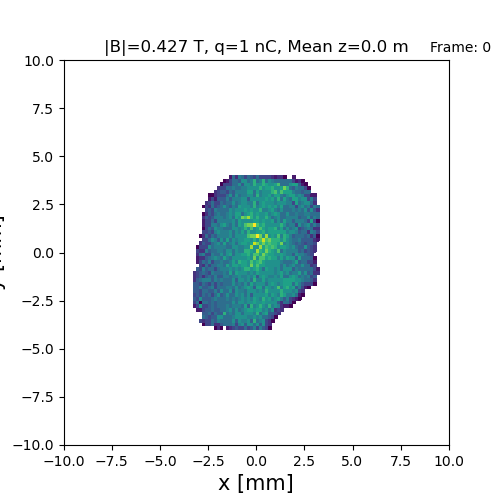

In [485]:
fig, axs = plt.subplots(figsize=(5, 5))
init_frame = 0
num_bins = 42
beam = xta.particles[init_frame]

data, x, y, _ = axs.hist2d(beam.x*10**3, beam.y*10**3, num_bins, cmin=1)
axs.set_title(f"|B|={xta.input['solenoid']['maxb(1)']} T, q={dist.input['total_charge']['value']} nC, Mean z={round(mean(beam.z), 3)} m")
axs.set_xlabel('x [mm]', size=15)
axs.set_ylabel('y [mm]', size=15)
axs.set(xlim =[left_xaxis, right_xaxis], ylim = [left_yaxis, right_yaxis])

frameCount = axs.text(right_xaxis-1, right_yaxis+0.4, f'Frame: {init_frame}')
pix = np.flipud(data.T)
im = plt.imshow(pix, extent=[x[0], x[-1], y[0], y[-1]])
#plt.close()

### Animating the histogram

In [486]:
def animate(i):
    plt.cla()
    beam = xta.particles[i]
    X = beam.x*10**3
    Y = beam.y*10**3
    data, x, y, _ = plt.hist2d(X, Y, num_bins, cmin=1)
    axs.set_title(f"|B|={xta.input['solenoid']['maxb(1)']} T, q={dist.input['total_charge']['value']} nC, Mean z={round(mean(beam.z), 3)} m")
    axs.set(xlim =[left_xaxis, right_xaxis], ylim = [left_yaxis, right_yaxis])
    axs.set_xlabel('x [mm]', size=15)
    axs.set_ylabel('y [mm]', size=15)
    frameCount.set_text(f'Frame: {i}')
    pix = np.flipud(data.T)
    im.set_data(pix)
    im.set_extent([x[0], x[-1], y[0], y[-1]])
    
num = len(xta.particles)
playback_speed = 6 #In fps
anim = animation.FuncAnimation(fig, animate, np.arange(1,num), repeat_delay = 2500, repeat = False)

#Save animation
writervideo = animation.FFMpegWriter(fps=playback_speed)
anim.save(f'{plots_path}/animations/{image_name}.mp4', writer=writervideo)

# Characterizing Beam Rotation

## Track movement of particles

In [487]:
def rotate_particles(frame):
    #initial and final particle groups
    init_part = xta.particles[0]
    fin_part = xta.particles[frame]

    #Picking a particle to track
    particleIndex = 100
    iPos = np.array([float(init_part[particleIndex].x), float(init_part[particleIndex].y)])
    iMag = np.sqrt(iPos.dot(iPos))
    fPos = np.array([float(fin_part[particleIndex].x), float(fin_part[particleIndex].y)])
    fMag = np.sqrt(fPos.dot(fPos))
    #This is negative since the rotation is clockwise
    diffAngle = -np.arccos((np.dot(iPos, fPos))/(iMag*fMag))


    #print(f'Initial Position: {iPos}')
    #print(f'Final Position: {fPos}')
    #print(f'Change in Angle: {round(math.degrees(diffAngle), 3)}')#Rotation transformation matrix
    R = np.array(((np.cos(diffAngle), -np.sin(diffAngle)), (np.sin(diffAngle), np.cos(diffAngle))))

    #2d Array of x and y points
    vect = np.vstack((fin_part.x*10**3, fin_part.y*10**3))

    #Applying rotation
    rotVect = R.dot(vect)
    return R.dot(vect)
rotVect = rotate_particles(-1)

## Plotting initial vs. final with rotation adjustment

In [488]:
fig, plots = plt.subplots(1, 2, figsize=(8.5, 4.25), sharex=True, sharey=True)
#fig.subplots_adjust(wspace=0.1)

#Final plot
finalxy = plt.subplot(1,2,2)
fin, x, y, _ = finalxy.hist2d(rotVect[0], rotVect[1], num_bins, facecolor='blue', cmin=1)
plots[1].set(title='Rotated Final Shape', xlabel='x [mm]')

#Initial Plot
initialxy = plt.subplot(1,2,1)
init, _, _, _ = plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, num_bins, facecolor='blue', cmin=1)
plots[0].set(title='Initial Shape', xlabel='x [mm]', ylabel='y [mm]', xlim=[left_xaxis, right_xaxis], ylim=[left_yaxis, right_yaxis])

plt.suptitle(f"|B|={xta.input['solenoid']['maxb(1)']} T, q={dist.input['total_charge']['value']} nC")

plt.savefig(f'{plots_path}/compare_dist_rotated/{image_name}.jpg', dpi=300, bbox_inches='tight')
plt.close()

## Saving Subplots

In [489]:
sub_bins = 42
fig, ax = plt.subplots(figsize=(5, 5), frameon=False)
plt.hist2d(xtapart.x*10**3, xtapart.y*10**3, sub_bins, facecolor='blue', cmin=1)
ax.set(xlim=[left_xaxis, right_xaxis], ylim=[left_yaxis, right_yaxis])
fig.savefig(f'{data_path}/cont_scan/init_{image_name}.jpg', bbox_inches='tight', pad_inches=0)

plt.close()

fig, ax = plt.subplots(figsize=(5, 5), frameon=False)
plt.hist2d(rotVect[0], rotVect[1], sub_bins, facecolor='blue', cmin=1)
ax.set(xlim=[left_xaxis, right_xaxis], ylim=[left_yaxis, right_yaxis])
fig.savefig(f'{data_path}/cont_scan/final_{image_name}.jpg', bbox_inches='tight', pad_inches=0)
plt.close()

# Statistics Plots Boiler Plate

In [490]:
#Initial, final, energy, beam size, bunch length, 
def boiler_plotplate(**kwargs):
    optionsDict = {'Initial': True, 'Final': True, 'Verbose':False, 'Rotate': True, 'BeamSize': True, 'BunchLength': True, 'FrameCount': True, 'xy_lim': [-4, 4]}
    plotsDict = {'Energy': True}
    for option, value in kwargs.items():
        try:
            optionsDict[option] = value
            plotsDict[option] = value
        except:
            pass
    
    if optionsDict['Verbose']:
        print('Options: ', optionsDict)
        print('Plots: ', plotsDict)
    
    if not optionsDict['Initial'] and not optionsDict['Final']:
        print('Nothing to plot, enable initial or final distributions')
        return
    num_rows = 2 if optionsDict['Initial'] and optionsDict['Final'] else 1

    #Determinining number of columns based on number of plots
    num_cols = 1
    for plot in plotsDict:
        if plotsDict[plot]:
            num_cols += 1
    
    #Generating the plots
    fig, plots = plt.subplots(num_rows, num_cols, figsize = (4*num_cols, 4*num_rows), sharex=True, sharey=True)

    #Final Plots
    if optionsDict['Final']:
        finalxy = plt.subplot(num_rows, num_cols, num_cols+1)
        plt.hist2d(rotVect[0], rotVect[1], num_bins, facecolor='blue', cmin=1) if optionsDict['Rotate'] else plt.hist2d(xta.particles[-1].x*10**3, xta.particles[-1].y*10**3, num_bins, facecolor='blue', cmin=1)
        plt.title('Final Distribution')
        for plot in plotsDict.items():
            print()
    #Initial Plots
    if optionsDict['Initial']:
        initalxy = plt.subplot(num_rows, num_cols, 1)
        plt.hist2d(xta.particles[0].x*10**3, xta.particles[0].y*10**3, num_bins, facecolor='blue', cmin=1)
        plt.title('Initial Distribution')
        plt.xlim(optionsDict['xy_lim'][0], optionsDict['xy_lim'][1])
        plt.ylim(optionsDict['xy_lim'][0], optionsDict['xy_lim'][1])

#boiler_plotplate()

# Comparitive Image Analysis

### Image Subtraction

In [491]:
def greyscale(image):
    return np.dot(image[...,:3], [0.33, 0.33, 0.33])

def subtractImg():
    initIm = greyscale(cv2.imread(f'{data_path}/cont_scan/init_{image_name}.jpg'))
    finIm = greyscale(cv2.imread(f'{data_path}/cont_scan/final_{image_name}.jpg'))
    diff = np.absolute(initIm-finIm)
    cv2.imwrite(f'{data_path}/cont_scan/diff_{image_name}.jpg', diff)

subtractImg()

# B Field Scanning

### Function that scores image likeness

In [492]:
def score(img):
    sumPixels = img.sum()
    squareSum = np.square(img).sum()
    return sumPixels

### Does a single simulation with specific B value (Histogram Image Subtraction)

In [493]:
def run(B):
    xta.input['solenoid']['maxb(1)'] = B
    xta.run()
    rotVect = rotate_particles(-1)
    fig, ax = plt.subplots(figsize=(5, 5), frameon=False)
    plt.hist2d(rotVect[0], rotVect[1], sub_bins, facecolor='blue', cmin=1)
    ax.set(xlim=[left_xaxis, right_xaxis], ylim=[left_yaxis, right_yaxis])
    fig.savefig(f'{data_path}/cont_scan/final_{image_name}.jpg', bbox_inches='tight', pad_inches=0)
    plt.close()
    subtractImg()
    subImg = plt.imread(f'{data_path}/cont_scan/diff_{image_name}.jpg')
    return score(subImg)

### Single B scan with greyscale subtraction, specific interval

In [494]:
def b_scan(min, max, scans, precision, verbose):
    if scans <= 3:
        raise ValueError('There must be more than 3 scans!')
    b_vals = np.linspace(min, max, scans)
    if verbose:
        print('Scanning B values: ', b_vals)
    opt_B = min
    opt_score = 1e9
    for B in b_vals:
        if verbose:
            print(f'\\nScanning {B} T')
        if B in scoreDict.keys():
            score = scoreDict[B]
            if verbose:
                print('Found in Dictionary!\\n')
        else:
            score = run(B)
            scoreDict[B] = score
        if verbose:
            print(f'\r\tScore: {score}')
        if score > opt_score:
            if B > opt_B:
                max_B = B
                break
            continue
        elif b_vals[-1] == B:
            raise ValueError('Upper limit is optimal limit, increase upper limit for proper scan!')
        min_B = opt_B
        opt_B = B
        opt_score = score
        opt_fin_img = plt.imread(f'{data_path}/cont_scan/final_{image_name}.jpg')
        opt_diff_img = plt.imread(f'{data_path}/cont_scan/diff_{image_name}.jpg')
        if verbose:
            print(f'\r\tOptimal B is now {B} T')

    #Cleanup plots
    plt.imsave(f'{data_path}/cont_scan/final_{image_name}.jpg', opt_fin_img)
    cv2.imwrite(f'{data_path}/cont_scan/diff_{image_name}.jpg', opt_diff_img)
    if verbose:
        print(f'\n The optimal B value is in between ({min_B} T, {max_B} T)')
    return opt_B, min_B, max_B

#Dictionary of previously scanned values
scoreDict = {}

#opt_B, min_B, max_B = b_scan(0.425, 0.43, 3)

### Continuous B scan, optimized to specificed decimal precision

In [495]:
def cont_scan(init_domain, scans_per_iteration, precision, verbose):
    min, max = init_domain
    while round(min, precision) != round(max, precision):
        if verbose:
            print(f'\n Starting new scan on interval ({min} T, {max} T)')
        opt_B, min, max = b_scan(min, max, scans_per_iteration, precision, verbose)
    if verbose:
        print('\n Continuous Scan Complete!')
        print(f'\r\tOptimal B: {round(opt_B, precision)} (Precision: {precision})')
    return opt_B
    
cont_scan([0.38, 0.45], 5, 2, verbose=False)

0.42703125

### X Projection Comparisons

Text(0.5, 0.98, 'Normalized $\\Delta$x')

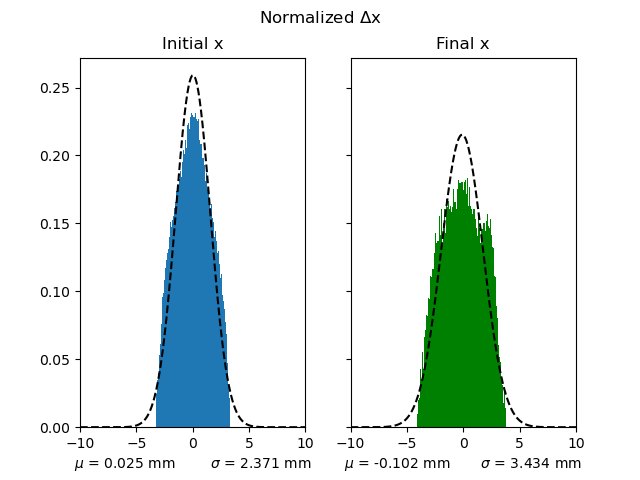

In [508]:
num_bins = 100

def gaus(data):
    avg = np.mean(data)
    var = np.var(data)
    gausx = np.linspace(left_xaxis, right_xaxis, 1000)
    gausy = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(gausx-avg)**2/var)
    return gausx, gausy, round(avg, 3), round(var, 3)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

#Final X
plt.subplot(1, 2, 2)
data = xta.particles[-1].x*10**3
finalx = plt.hist(data, num_bins, density=True, facecolor='green')
gausx, gausy, avg, var = gaus(data)
plt.plot(gausx, gausy, 'k--')
plt.title('Final x')
plt.xlabel(f'$\mu$ = {avg} mm\t$\sigma$ = {var} mm')

#Initial X
plt.subplot(1, 2, 1)
data = xta.particles[0].x*10**3
initx = plt.hist(data, num_bins, density=True)
gausx, gausy, avg, var = gaus(data)
plt.plot(gausx, gausy, 'k--')
plt.title('Initial x')
plt.xlim(left_xaxis, right_xaxis)
plt.xlabel(f'$\mu$ = {avg} mm\t$\sigma$ = {var} mm')

plt.suptitle('Normalized $\Delta$x')
#plt.close()

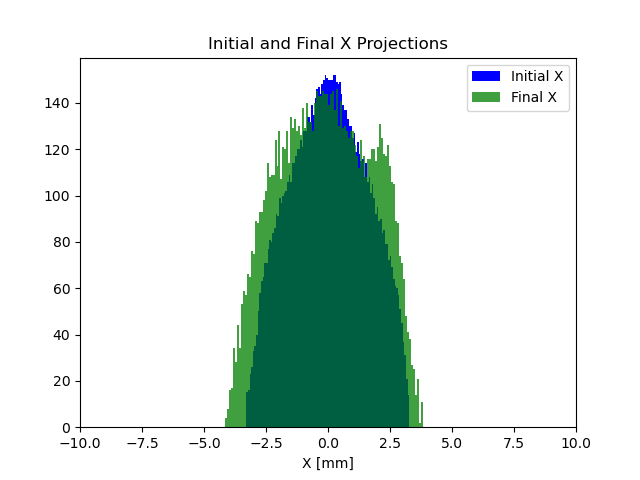

In [509]:
plt.figure()
plt.title('Initial and Final X Projections')
plt.hist(xta.particles[0].x*10**3, num_bins, facecolor='blue', label='Initial X', alpha=1)
plt.hist(xta.particles[-1].x*10**3, num_bins, facecolor='green', label='Final X', alpha=0.75)
plt.xlim(left_xaxis, right_xaxis)
plt.xlabel('X [mm]')
plt.legend()
plt.show()
#plt.close()

### Y Projection Comparisons

/var/folders/7v/99k259ns555d7fv71_7wxrmm0000gn/T/ipykernel_97960/1108242256.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)


Text(0.5, 0.98, 'Normalized $\\Delta$y')

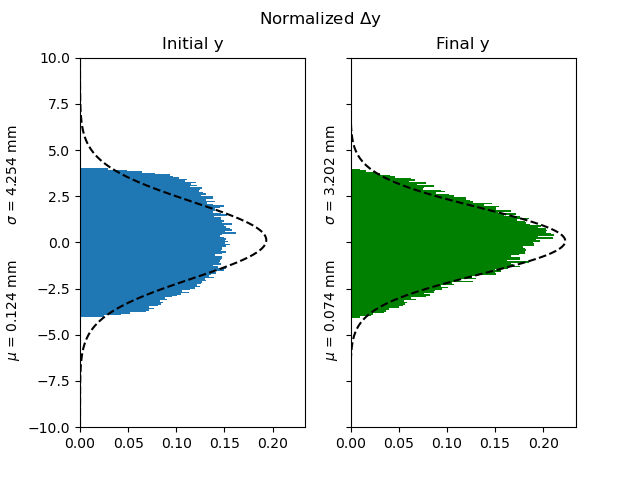

In [510]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

plt.subplot(1, 2, 2)
data = xta.particles[-1].y*10**3
finalx = plt.hist(data, num_bins, density=True, facecolor='green', orientation='horizontal')
gausy, gausx, avg, var = gaus(data)
plt.plot(gausx, gausy, 'k--')
plt.title('Final y')
plt.ylabel(f'$\mu$ = {avg} mm\t$\sigma$ = {var} mm')

plt.subplot(1, 2, 1)
data = xta.particles[0].y*10**3
initx = plt.hist(data, num_bins, density=True, orientation='horizontal')
gausy, gausx, avg, var = gaus(data)
plt.plot(gausx, gausy, 'k--')
plt.title('Initial y')
plt.ylim(left_yaxis, right_yaxis)
plt.ylabel(f'$\mu$ = {avg} mm\t$\sigma$ = {var} mm')

plt.suptitle('Normalized $\Delta$y')
#plt.close()

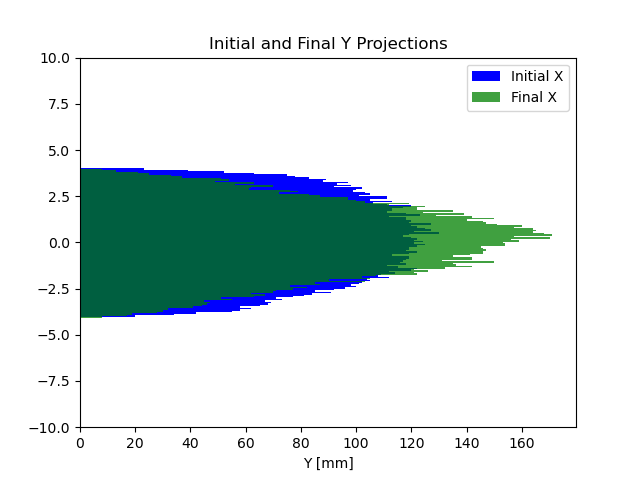

In [511]:
plt.figure()
plt.title('Initial and Final Y Projections')
plt.hist(xta.particles[0].y*10**3, num_bins, facecolor='blue', label='Initial X', alpha=1, orientation='horizontal')
plt.hist(xta.particles[-1].y*10**3, num_bins, facecolor='green', label='Final X', alpha=0.75, orientation='horizontal')
plt.ylim(left_yaxis, right_yaxis)
plt.xlabel('Y [mm]')
plt.legend()
plt.show()
#plt.close()